In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [3]:
# Train-test split

train_size = int(len(df) * 0.8) 

train_df,test_df = df[1:train_size], df[train_size:] 

In [4]:
test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [5]:
# Scaling

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [6]:
# Now we will make a function that will use a sliding window approach to transform our series into samples 
# of input past observations and output future observations to use supervised learning algorithms.

# FUNCTION
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [11]:
# Convert train and test data:

# Variables
n_past = 60
n_future = 136
n_features = 6

# CALLS
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [12]:
X_train.shape

(604, 60, 6)

In [13]:
X_test.shape

(5, 60, 6)

In [14]:
y_train.shape

(604, 136, 6)

In [15]:
y_test.shape

(5, 136, 6)

# Multivariate model

In [16]:
# Doesn't work like this but technically its the same as the stuff below (?) -- For simplicity look at this

# Model 1: E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [17]:
# E1D1
# n_features ==> no of features at each timestep in the data.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = enimcoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.Huber())

history = model.fit(
                    X_train, y_train, 
                    batch_size=256, 
                    epochs=100, 
                    validation_data=(X_test,y_test)
                   )

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

Epoch 1/100
3/3 [==============================] - 1s 498ms/step - loss: 0.1826 - val_loss: 0.2354
Epoch 2/100
3/3 [==============================] - 1s 246ms/step - loss: 0.1817 - val_loss: 0.2340
Epoch 3/100
3/3 [==============================] - 1s 249ms/step - loss: 0.1810 - val_loss: 0.2331
Epoch 4/100
3/3 [==============================] - 1s 256ms/step - loss: 0.1802 - val_loss: 0.2321
Epoch 5/100
3/3 [==============================] - 1s 249ms/step - loss: 0.1794 - val_loss: 0.2308
Epoch 6/100
3/3 [==============================] - 1s 268ms/step - loss: 0.1782 - val_loss: 0.2291
Epoch 7/100
3/3 [==============================] - 1s 269ms/step - loss: 0.1766 - val_loss: 0.2261
Epoch 8/100
3/3 [==============================] - 1s 245ms/step - loss: 0.1737 - val_loss: 0.2200
Epoch 9/100
3/3 [==============================] - 1s 260ms/step - loss: 0.1673 - val_loss: 0.2027
Epoch 10/100
3/3 [==============================] - 1s 260ms/step - loss: 0.1423 - val_loss: 0.1323
Epoch 11/

3/3 [==============================] - 1s 361ms/step - loss: 0.0025 - val_loss: 0.0129
Epoch 84/100
3/3 [==============================] - 1s 361ms/step - loss: 0.0023 - val_loss: 0.0114
Epoch 85/100
3/3 [==============================] - 1s 391ms/step - loss: 0.0022 - val_loss: 0.0115
Epoch 86/100
3/3 [==============================] - 1s 361ms/step - loss: 0.0020 - val_loss: 0.0110
Epoch 87/100
3/3 [==============================] - 1s 376ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 88/100
3/3 [==============================] - 1s 370ms/step - loss: 0.0019 - val_loss: 0.0128
Epoch 89/100
3/3 [==============================] - 1s 405ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 90/100
3/3 [==============================] - 1s 405ms/step - loss: 0.0018 - val_loss: 0.0124
Epoch 91/100
3/3 [==============================] - 1s 410ms/step - loss: 0.0017 - val_loss: 0.0129
Epoch 92/100
3/3 [==============================] - 1s 401ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 93/100


In [18]:
pred = model.predict(X_test)
pred.shape

(5, 136, 6)

In [19]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    #y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
y_test.shape

(5, 136, 6)

Pred vs test of Feature 0 (x):

In [113]:
y_test[0,:,0]

array([ 36469.11006238,  29881.87362072,  19126.08641357,   5668.28662176,
        -8580.68636836, -21580.77033154, -31508.40559114, -37025.09594659,
       -37423.65401184, -32679.21080377, -23442.55060601, -10978.72035769,
         2985.7054782 ,  16520.84509467,  27798.55840532,  35344.6529504 ,
        38188.59658665,  35937.84933107,  28822.74069404,  17720.63777403,
         4114.25199323, -10076.80861617, -22801.97239595, -32242.02806097,
       -37102.74134816, -36769.24757745, -31336.97455908, -21571.53138319,
        -8818.30767242,   5160.81489587,  18443.01905644,  29245.27551094,
        36173.05174199,  38358.08582002,  35508.90974646,  27930.06425218,
        16532.92597256,   2803.99330865, -11337.25085958, -23827.15132184,
       -32834.79545718, -37090.67245283, -36060.64730559, -29961.60688874,
       -19682.2591247 ,  -6654.86141998,   7325.09001583,  20349.69801356,
        30687.39019716,  37022.46297369,  38582.7040899 ,  35170.55413207,
        27159.65660567,  

In [114]:
pred[0,:,0]

array([ 32956.88   ,  25898.61   ,  14722.96   ,    865.08386,
       -13554.914  , -26329.541  , -35601.707  , -39986.16   ,
       -38904.38   , -32838.574  , -22747.582  ,  -9503.583  ,
         5255.662  ,  19389.979  ,  30788.424  ,  37699.336  ,
        39227.13   ,  35463.836  ,  27004.902  ,  14853.24   ,
          705.24194, -13386.51   , -25509.736  , -34025.914  ,
       -37693.266  , -36038.664  , -29612.252  , -19479.53   ,
        -6492.0576 ,   7778.222  ,  21208.174  ,  31739.281  ,
        37748.95   ,  38496.598  ,  34142.56   ,  25291.604  ,
        13008.444  ,   -977.5459 , -14664.805  , -26209.1    ,
       -34027.85   , -36964.09   , -34668.547  , -27790.574  ,
       -17361.322  ,  -4267.8345 ,   9817.198  ,  22776.717  ,
        32607.094  ,  37803.895  ,  37774.28   ,  32757.58   ,
        23398.467  ,  10852.997  ,  -3089.5872 , -16449.31   ,
       -27428.666  , -34499.562  , -36609.004  , -33560.875  ,
       -26119.896  , -15273.186  ,  -1977.0988 ,  11982

## Visualizations:

0


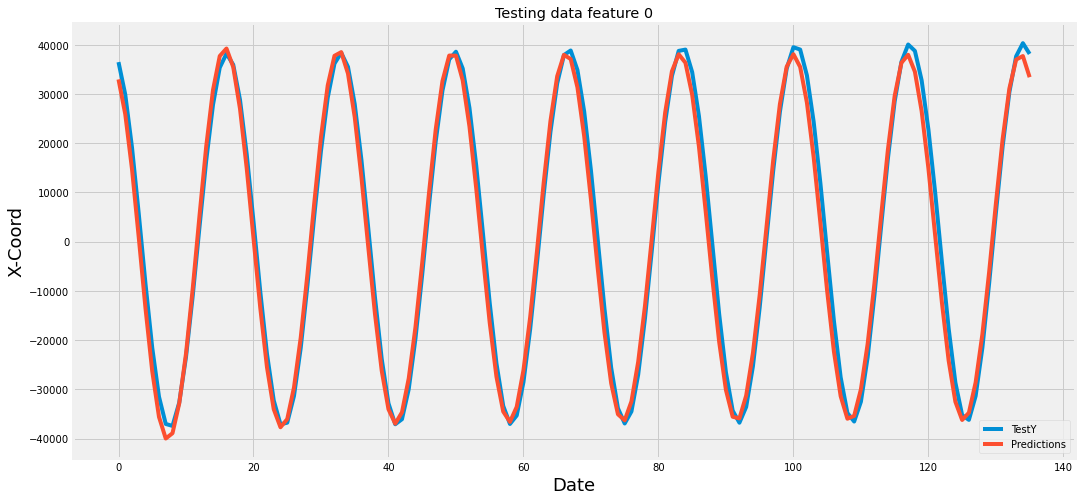

1


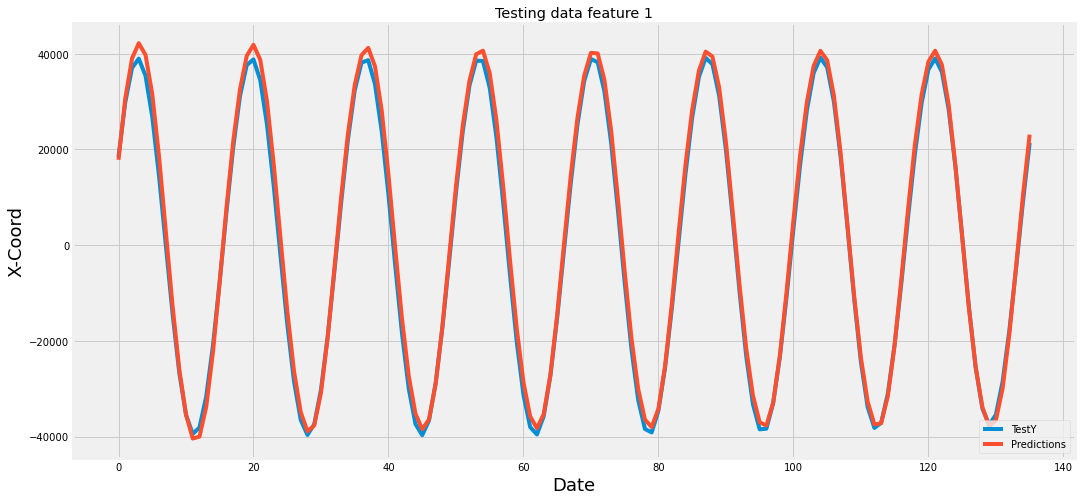

2


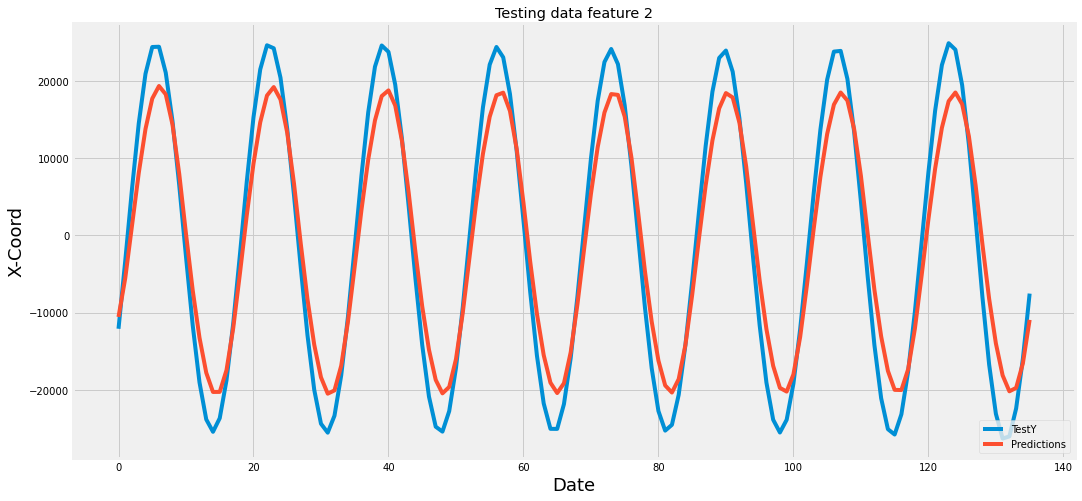

3


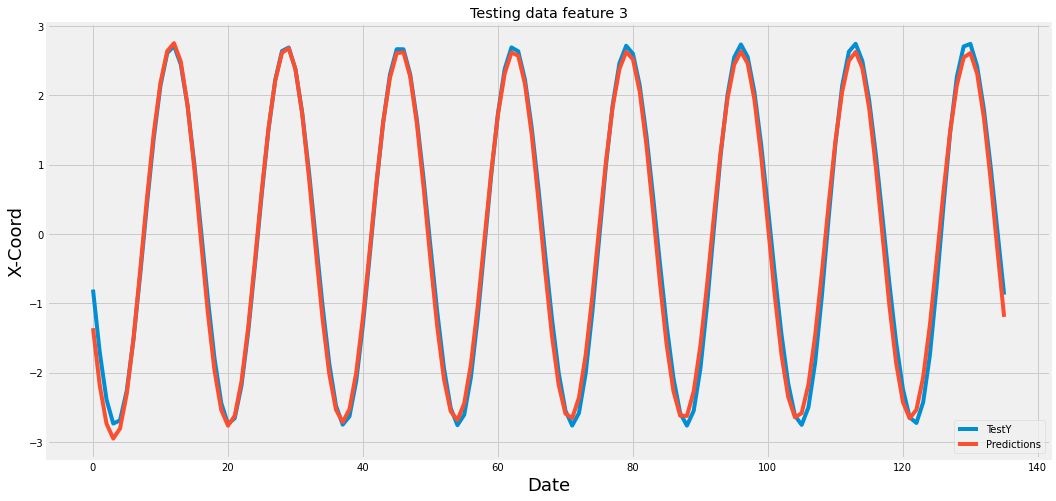

4


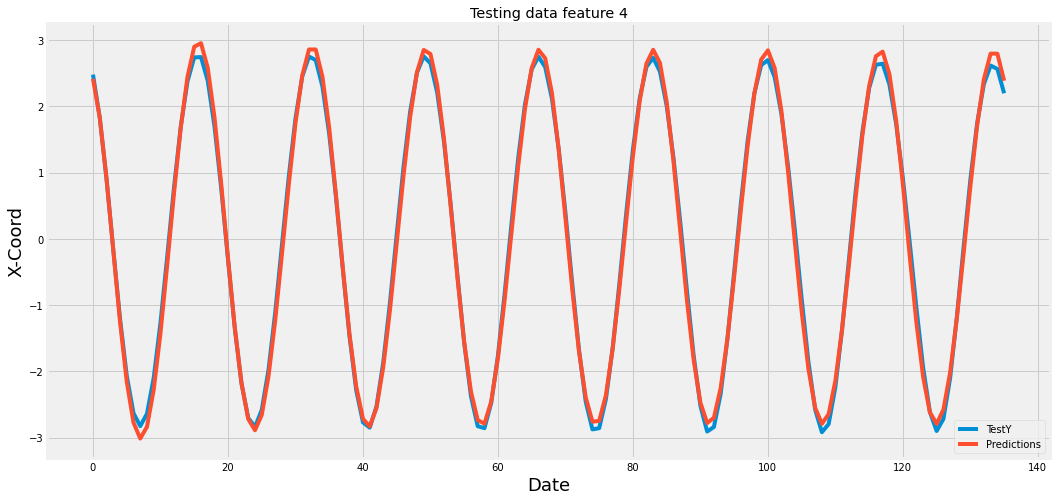

5


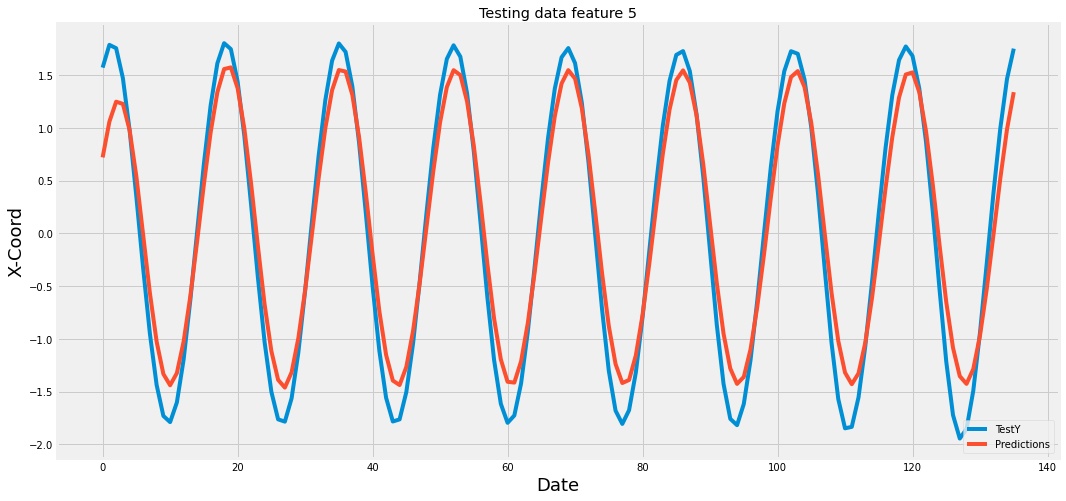

In [121]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    plt.figure(figsize=(16,8))
    #plt.title(f'Testing data feature {i}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('X-Coord', fontsize=18)
    plt.plot(dff.testY)
    plt.plot(dff.predictions)
    plt.legend(['TestY', 'Predictions'], loc='lower right')
    plt.show()

## RMSE:

In [117]:
# RMSE CORRECT Formula

print('RMSE for Features 0-5:')
print()
for i in range(0,6):
    rmse = np.sqrt(np.mean(((pred[0,:,i] - y_test[0,:,i]) ** 2))) #3rd var is index/feature no
    print(rmse)

RMSE for Features 0-5:

3412.412299931971
1962.159195935328
4773.562140536815
0.17836714490967026
0.10559730179245572
0.3034062307010025


In [118]:
# RMSE CORRECT Formula

print('RMSE for Features 0-5:')
print()
for i in range(0,6):
    rmse = np.sqrt(mean_squared_error(y_test[0,:,i], pred[0,:,i]))
    print(rmse)

RMSE for Features 0-5:

3412.412299931971
1962.159195935328
4773.562140536815
0.17836714490967026
0.10559730179245572
0.3034062307010025


RMSE is not a step-by-step error, just the mean. So it's only 1 value per test per feature.

## Errors:

### 1. Absolute errors:

0


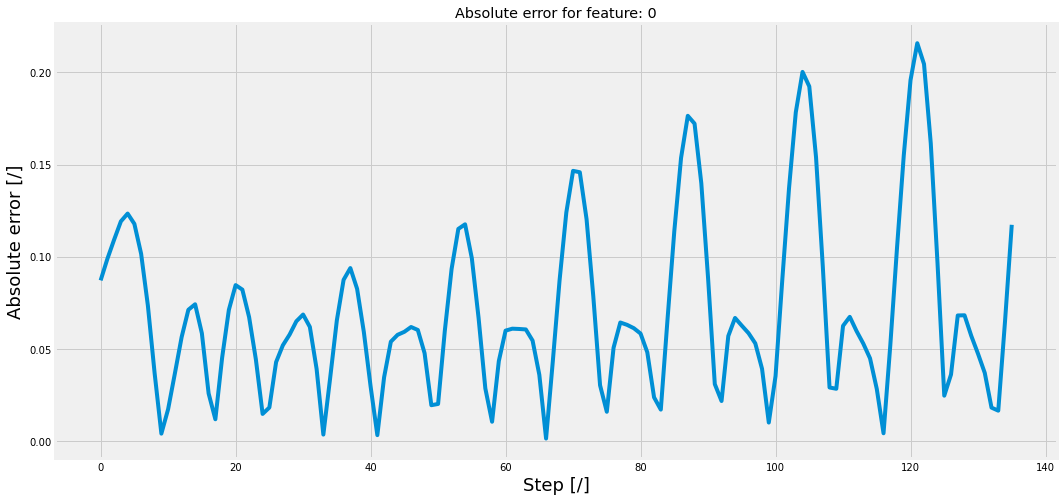

1


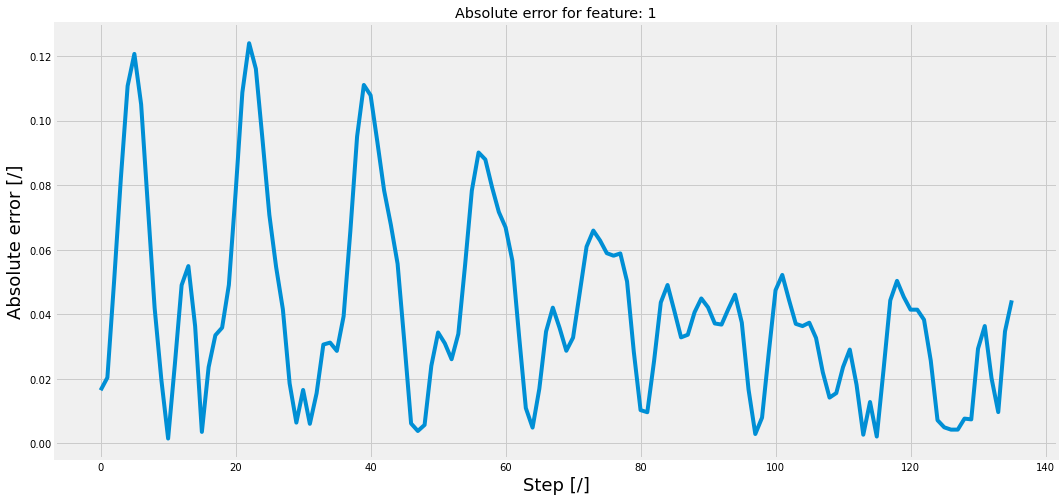

2


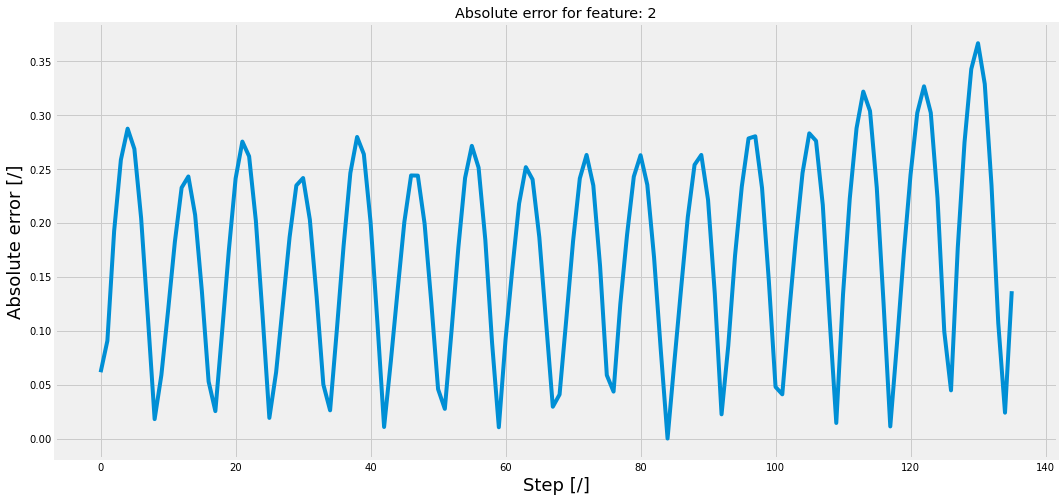

3


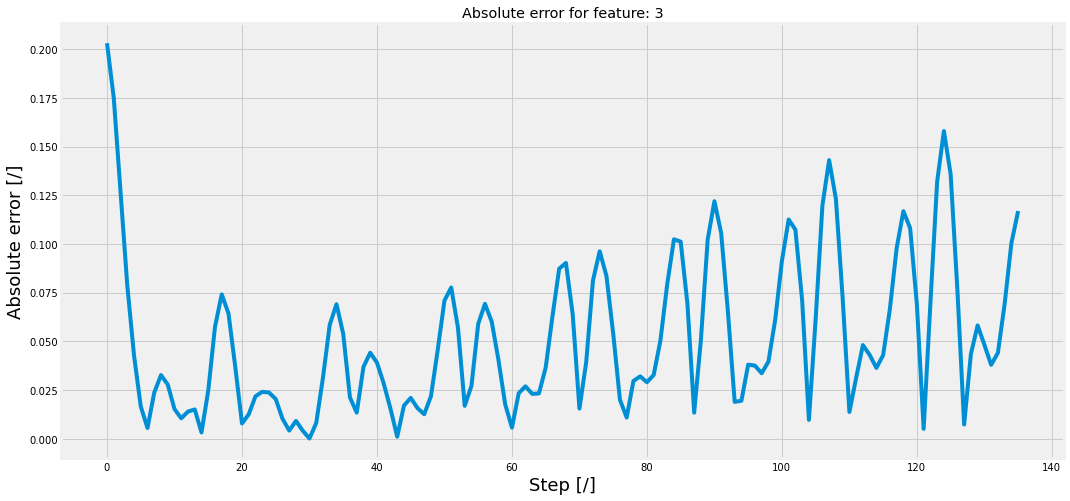

4


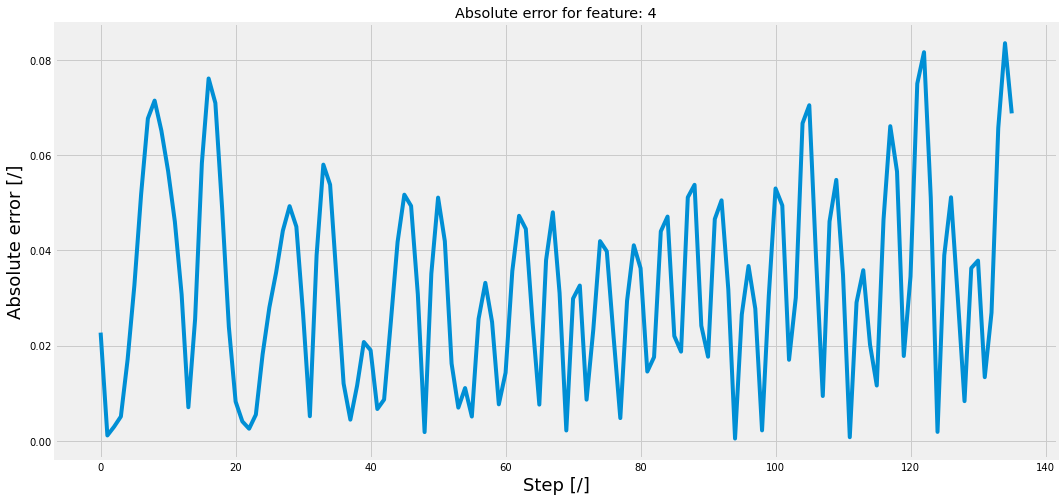

5


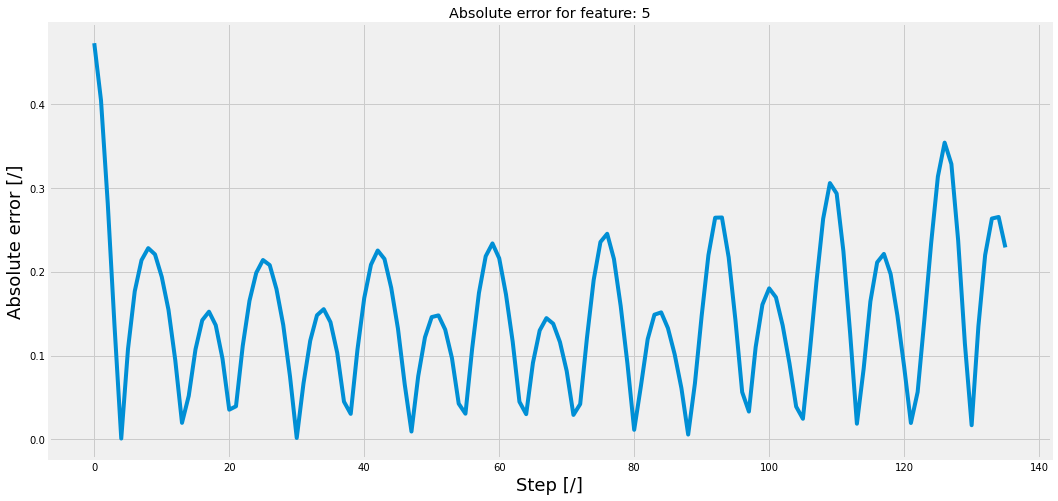

In [157]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as ISS semi-major axis
    plt.figure(figsize=(16,8))
    plt.title('Absolute error for feature: '+str(i))
    plt.xlabel('Step [/]', fontsize=18)
    plt.ylabel('Absolute error [/]', fontsize=18)
    plt.plot(dff.Error)
    plt.show()

### 2. Relative errors:

0


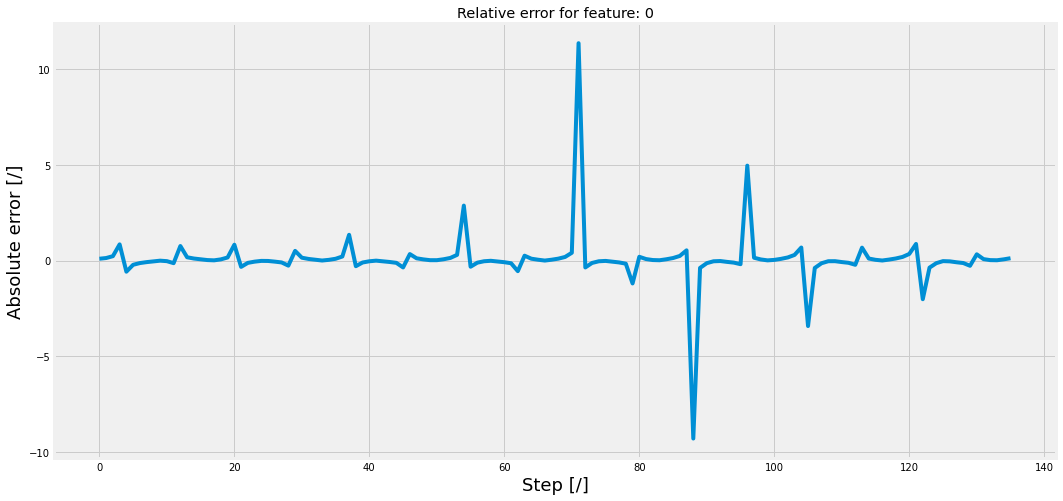

1


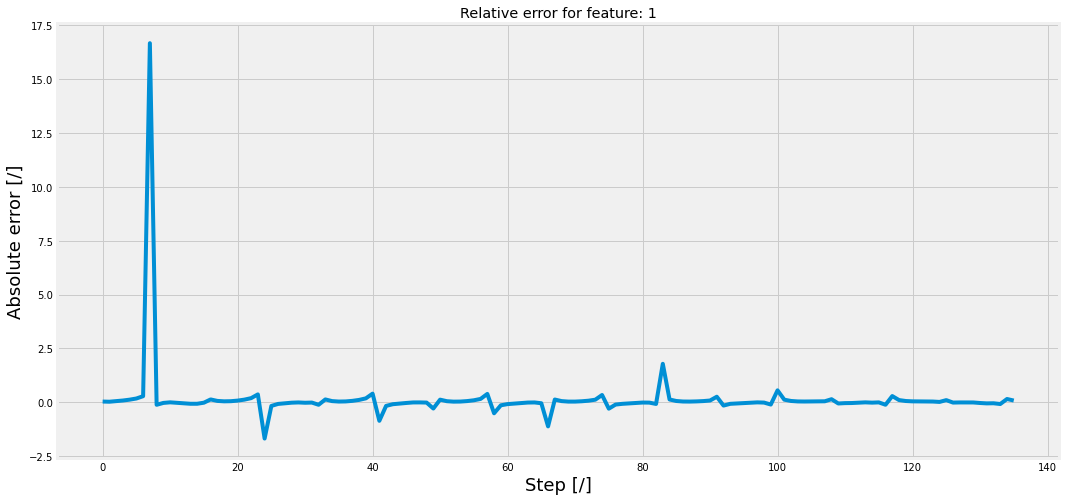

2


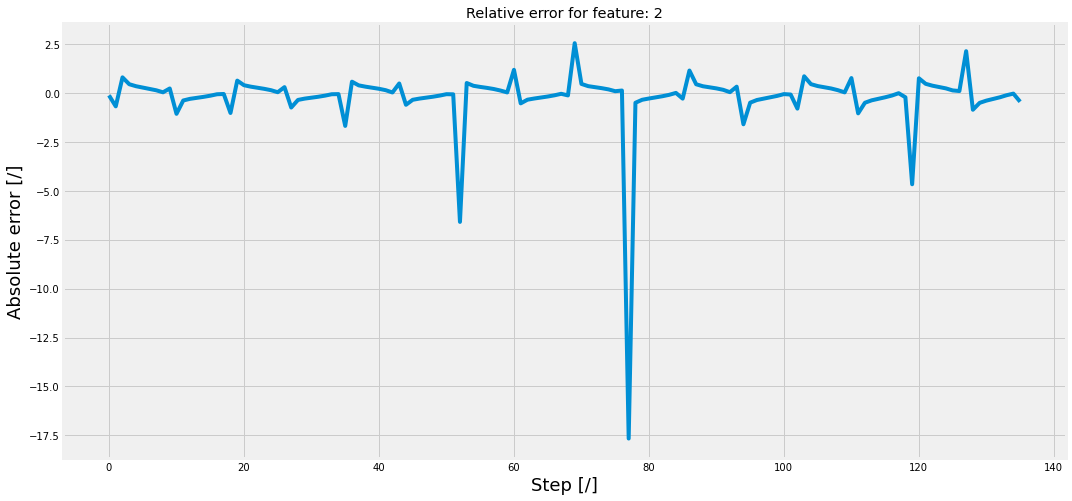

3


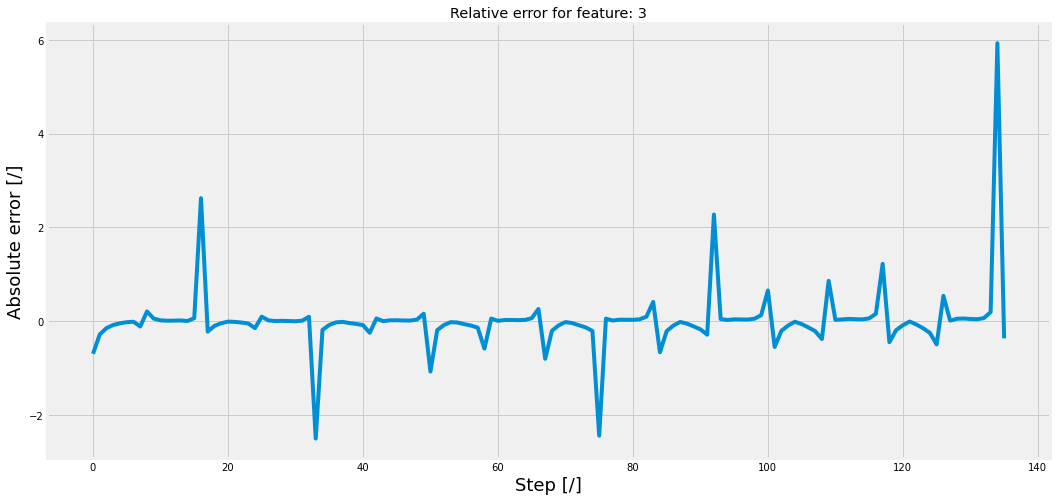

4


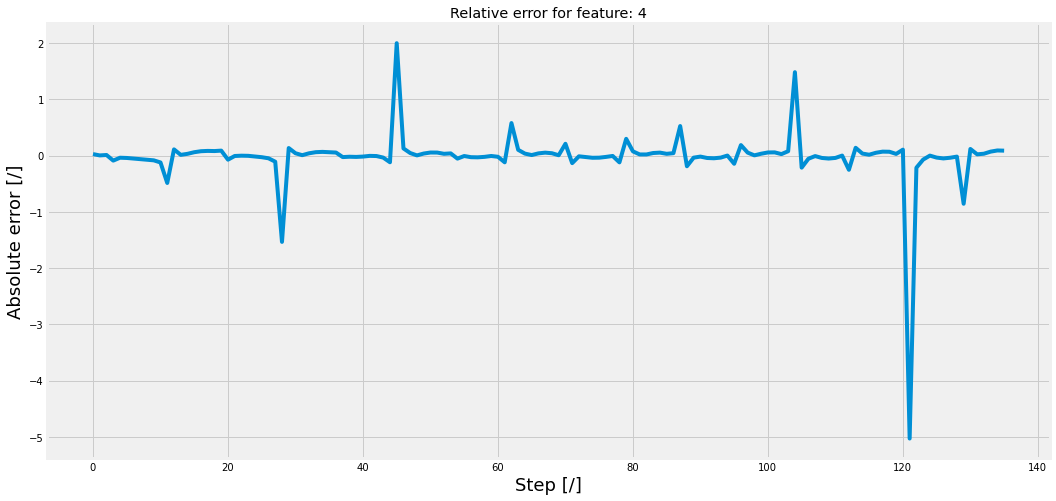

5


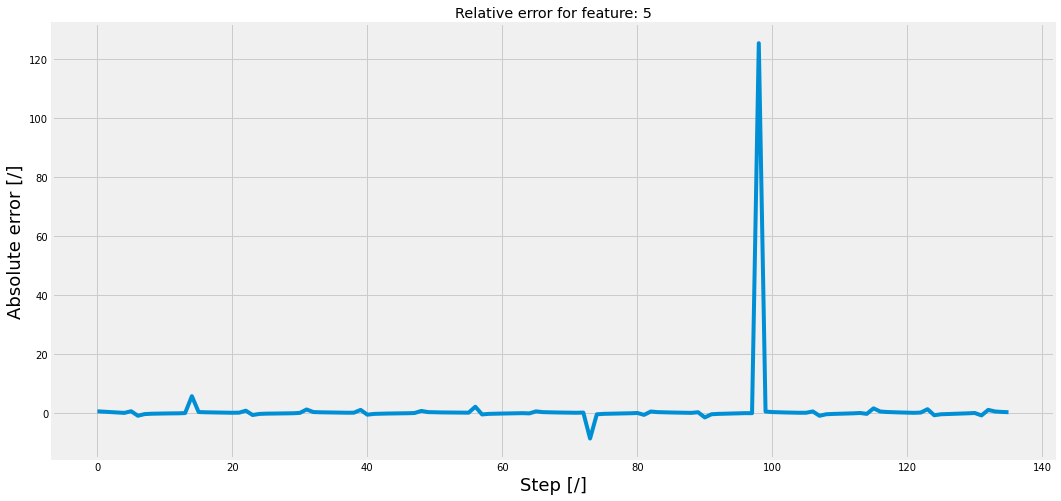

In [158]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/dff.testY # the normalization ct is taken as ISS semi-major axis
    plt.figure(figsize=(16,8))
    plt.title('Relative error for feature: '+str(i))
    plt.xlabel('Step [/]', fontsize=18)
    plt.ylabel('Absolute error [/]', fontsize=18)
    plt.plot(dff.Error)
    plt.show()

### 3. 3D Plots

Distance 3D:

In [146]:
df_pred=pd.DataFrame(columns=['x','y','z'])
test_df=pd.DataFrame(columns=['x','y','z'])

df_pred['x'] = pred[0,:,0]
df_pred['y'] = pred[0,:,1]
df_pred['z'] = pred[0,:,2]

test_df['x'] = y_test[0,:,0]
test_df['y'] = y_test[0,:,1]
test_df['z'] = y_test[0,:,2]

<Figure size 432x288 with 0 Axes>

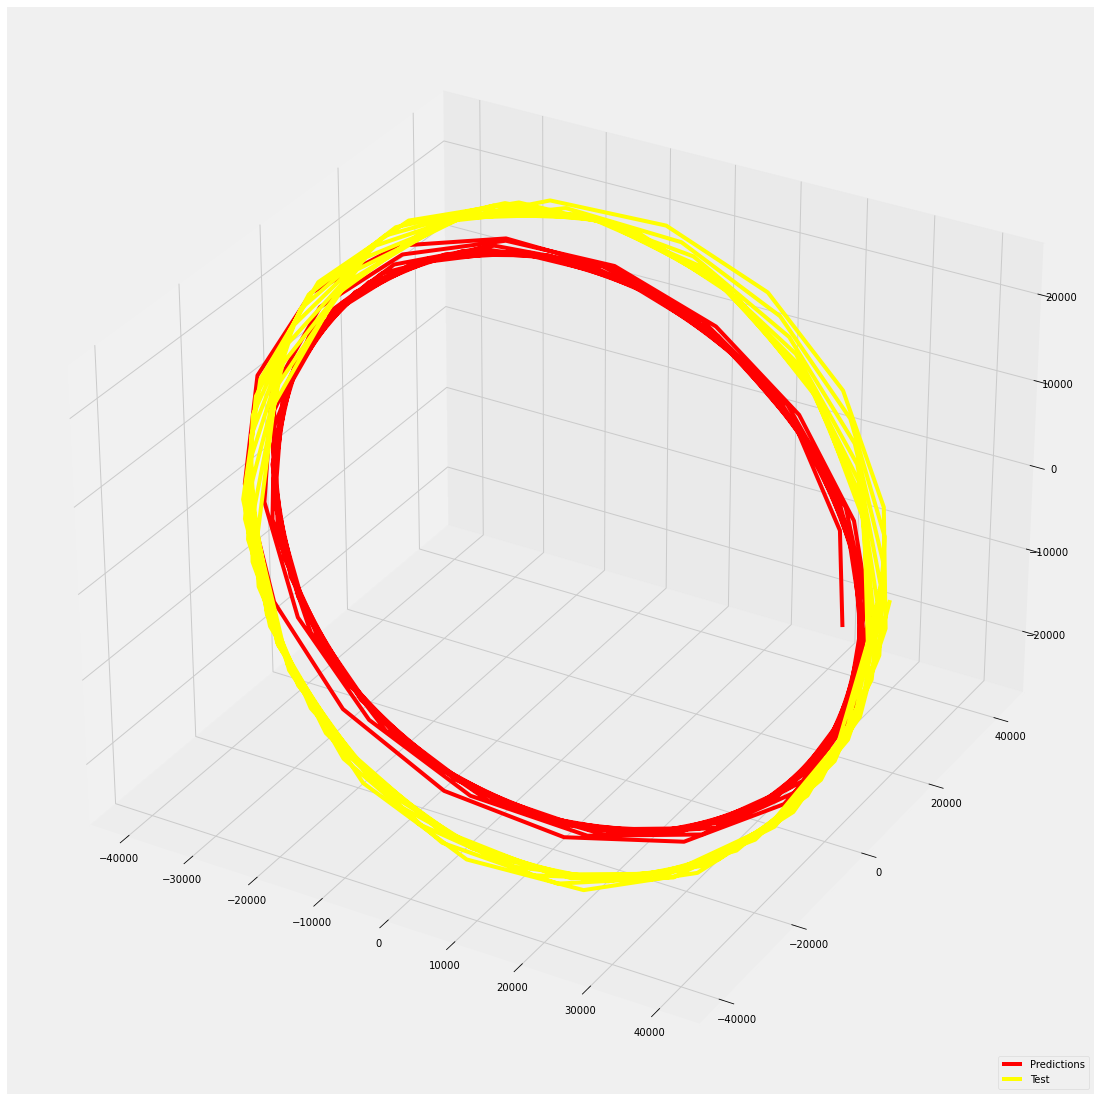

In [147]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

Velocities 3D:

In [148]:
df_pred=pd.DataFrame(columns=['x_vv','y_vv','z_vv'])
test_df=pd.DataFrame(columns=['x_vv','y_vv','z_vv'])

df_pred['x_vv'] = pred[0,:,3]
df_pred['y_vv'] = pred[0,:,4]
df_pred['z_vv'] = pred[0,:,5]

test_df['x_vv'] = y_test[0,:,3]
test_df['y_vv'] = y_test[0,:,4]
test_df['z_vv'] = y_test[0,:,5]

<Figure size 432x288 with 0 Axes>

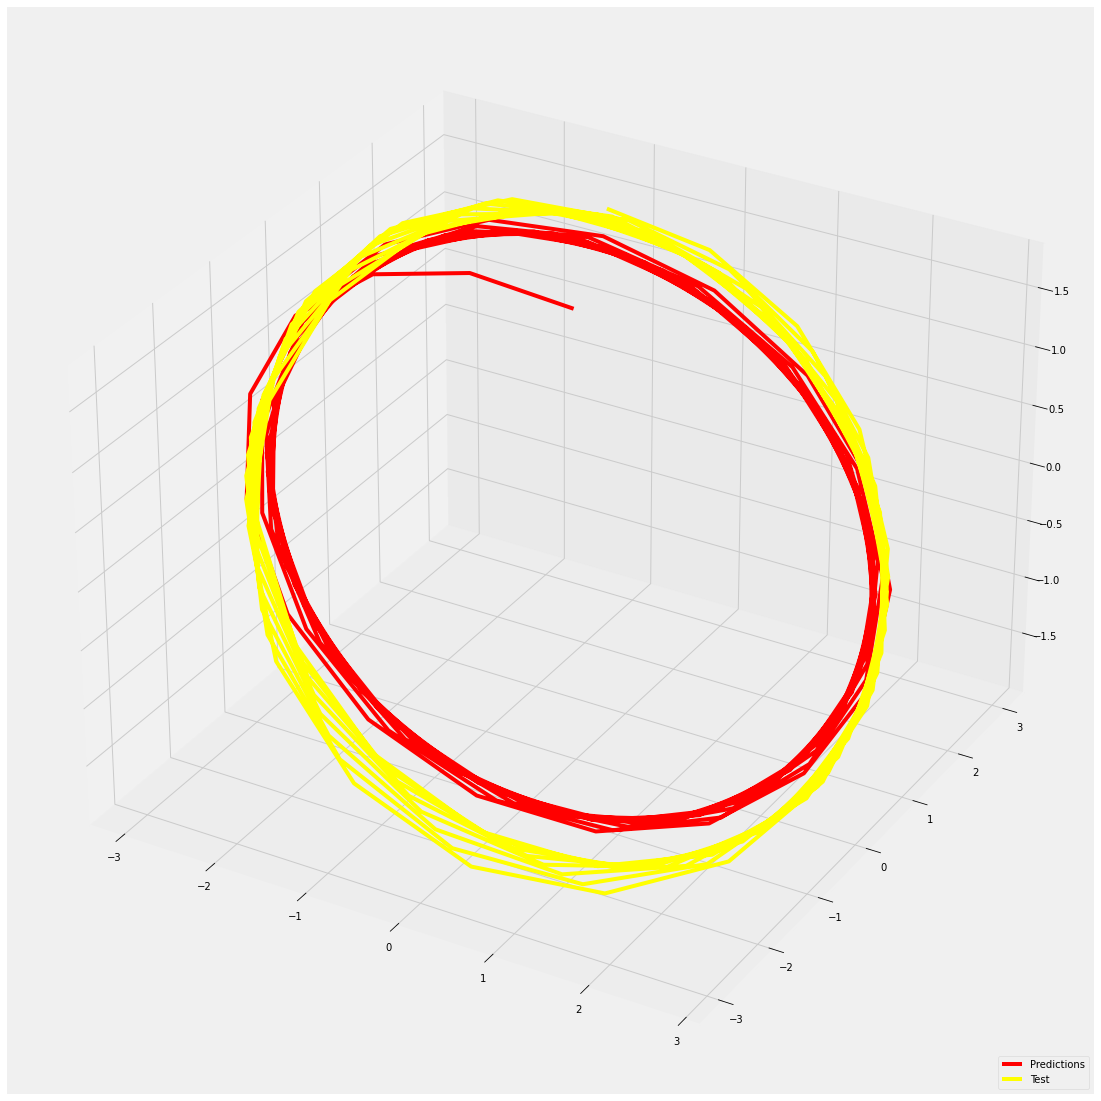

In [149]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x_vv']
y_line = df_pred['y_vv']
z_line = df_pred['z_vv']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x_vv']
y_line2 = test_df['y_vv']
z_line2 = test_df['z_vv']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

### 4. 3D Distance error:

In [150]:
df_pred=pd.DataFrame(columns=['x','y','z'])
test_df=pd.DataFrame(columns=['x','y','z'])

df_pred['x'] = pred[0,:,0]
df_pred['y'] = pred[0,:,1]
df_pred['z'] = pred[0,:,2]

test_df['x'] = y_test[0,:,0]
test_df['y'] = y_test[0,:,1]
test_df['z'] = y_test[0,:,2]

In [151]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

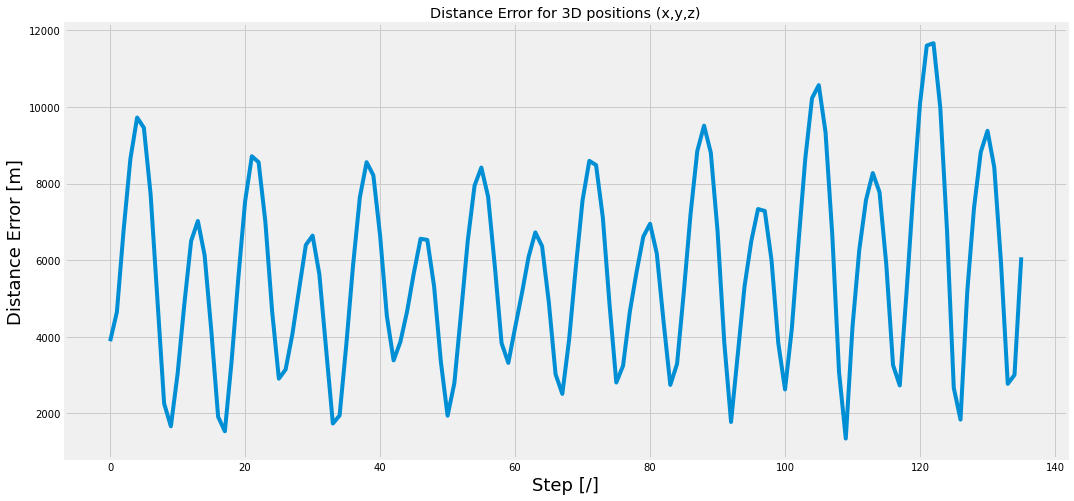

In [160]:
# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))

# 3D Distance difference plot vs time-stamp
plt.figure(figsize=(16,8))
plt.plot(df_err.distance_error)
plt.title('Distance Error for 3D positions (x,y,z)')
plt.xlabel('Step [/]', fontsize=18)
plt.ylabel('Distance Error [m]', fontsize=18)
plt.show()